# **CANCELLATIONS ANALYSIS WORKBOOK**

## Objectives

* Answer business requirement 1:
  - The client wants to understand patterns in booking cancellations and determine which variables are most associated/correlated with cancellations.

## Inputs

* **Cleaned Dataset with Duplicates Removed:** outputs/{version}/datasets/cleaned/cleaned_deduplicated.csv
* **Cleaned Dataset with All Records:** outputs/{version}/datasets/cleaned/cleaned_all_records.csv

## Outputs

* Code that answers business requirement 1 and can be used to build the Streamlit App

---

# Import Packages, Load Data and Initialise Useful Variables

Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Specify project version

In [2]:
version = 'v1'

Load data

In [3]:
from pathlib import Path

project_root = Path.cwd().parent
cleaned_datasets_dir = project_root / 'outputs' / version / 'datasets' / 'cleaned'

cleaned_all = cleaned_datasets_dir / 'cleaned_all_records.csv'
cleaned_deduplicated = cleaned_datasets_dir / 'cleaned_deduplicated.csv'

try:
    df_all = pd.read_csv(cleaned_all)
    df_deduplicated = pd.read_csv(cleaned_deduplicated)
except FileNotFoundError as e:
    print(f"ERROR: Could not find file for specified project version '{version}'\n{e}")
except Exception as e:
    print(f"ERROR: Unexpected error occurred. {e}")
else:
    print("SUCCESS: Datasets have been loaded")


SUCCESS: Datasets have been loaded


`df_deduplicated` will mainly be used in the following analysis because it allows us to study patterns and drivers of cancellations (per unique booking type) without over-representing certain types of bookings.

In [4]:
df = df_deduplicated.copy()

---

# Change Data Types

View current data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79505 entries, 0 to 79504
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           79505 non-null  object 
 1   is_canceled                     79505 non-null  bool   
 2   lead_time                       79505 non-null  int64  
 3   arrival_date_year               79505 non-null  int64  
 4   arrival_date_month              79505 non-null  object 
 5   arrival_date_week_number        79505 non-null  int64  
 6   arrival_date_day_of_month       79505 non-null  int64  
 7   stays_in_weekend_nights         79505 non-null  int64  
 8   stays_in_week_nights            79505 non-null  int64  
 9   adults                          79505 non-null  int64  
 10  children                        79505 non-null  int64  
 11  babies                          79505 non-null  int64  
 12  meal                            

Change data types

In [6]:
# Convert objects to type 'category' (for efficiency and performance)
obj_cols = df.select_dtypes(include='object').columns.to_list()
df[obj_cols] = df[obj_cols].astype('category')

# Convert ints that are really categories
int_to_cat_cols = ['agent', 'company']
df[int_to_cat_cols] = df[int_to_cat_cols].astype('category')

# Convert dates
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79505 entries, 0 to 79504
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   hotel                           79505 non-null  category
 1   is_canceled                     79505 non-null  bool    
 2   lead_time                       79505 non-null  int64   
 3   arrival_date_year               79505 non-null  int64   
 4   arrival_date_month              79505 non-null  category
 5   arrival_date_week_number        79505 non-null  int64   
 6   arrival_date_day_of_month       79505 non-null  int64   
 7   stays_in_weekend_nights         79505 non-null  int64   
 8   stays_in_week_nights            79505 non-null  int64   
 9   adults                          79505 non-null  int64   
 10  children                        79505 non-null  int64   
 11  babies                          79505 non-null  int64   
 12  meal              

---

# Useful Variables and Functions

Useful variables

In [7]:
target = 'is_canceled'

---

# Correlation Studies

We will explore whether any features correlate strongly with booking cancellations using the dataset with duplicate records removed.

We will analyse:
1. All record types (both unique and duplicated)
2. Unique vs duplicated records
3. City hotel vs resort hotel

It would not be appropriate to use the Pearson method for calculating correlations since most variables are NOT continuous numeric variables with normal distributions. Therefore, we will use Spearman correlation coefficients throughout this analysis.

## Prepare data

In [8]:
df_corr = df.copy()

Drop `reservation_status` (since it overlaps strongly with `is_canceled`)

In [9]:
df_corr.drop('reservation_status', axis=1, inplace=True)

Encode `hotel` and boolean features as integers 

In [10]:
# Encode hotel type
hotel_map = {'City Hotel': 0, 'Resort Hotel': 1}
df_corr['hotel'] = df_corr['hotel'].map(hotel_map).astype('int')

# Convert booleans to integers
bool_cols = df_corr.select_dtypes('bool').columns.to_list()
df_corr[bool_cols] = df_corr[bool_cols].astype('int')

df_corr.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,record_count
0,0,1,277,2016,November,46,7,1,2,2,...,Non Refund,0,0,0,Transient,100.0,0,0,2016-04-04,180
1,0,1,68,2016,February,8,17,0,2,2,...,Non Refund,37,0,0,Transient,75.0,0,0,2016-01-06,150
2,0,1,188,2016,June,25,15,0,2,1,...,Non Refund,119,0,39,Transient,130.0,0,0,2016-01-18,109


Get all numeric columns (including those encoded above) for using with correlation heatmaps

In [11]:
numeric_cols = df_corr.select_dtypes('number').columns.to_list()

# Move target to first column (for easier analysis)
numeric_cols.remove(target)
numeric_cols.insert(0, target)

Get categorical features and separate into those with
- low cardinality (<15 categories): for one-hot encoding
- high cardinality (15+ categories): to exclude from correlation analysis

In [12]:
# Get all categorical features as a list
cat_cols = df_corr.select_dtypes(include=['object', 'category']).columns.to_list()

# Get low cardinality categorical features
low_card_cats = [col for col in cat_cols if (3 <= df_corr[col].nunique() < 15)]
print('Low cardinality features will be encoded:\n', low_card_cats)

# Get high cardinality categorical features and drop from dataframe
high_card_cats = [col for col in cat_cols if df_corr[col].nunique() >= 15]
print('\nHigh cardinality features will be dropped from dataframe:\n', high_card_cats)

Low cardinality features will be encoded:
 ['arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

High cardinality features will be dropped from dataframe:
 ['country', 'agent', 'company', 'reservation_status_date']


One-hot encode categorical features with low cardinality

In [13]:
from feature_engine.encoding import OneHotEncoder

encoder = OneHotEncoder(variables=low_card_cats, drop_last=False)
df_corr = encoder.fit_transform(df_corr)
df_corr.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,assigned_room_type_K,assigned_room_type_I,assigned_room_type_L,deposit_type_Non Refund,deposit_type_No Deposit,deposit_type_Refundable,customer_type_Transient,customer_type_Transient-Party,customer_type_Contract,customer_type_Group
0,0,1,277,2016,46,7,1,2,2,0,...,0,0,0,1,0,0,1,0,0,0
1,0,1,68,2016,8,17,0,2,2,0,...,0,0,0,1,0,0,1,0,0,0
2,0,1,188,2016,25,15,0,2,1,0,...,0,0,0,1,0,0,1,0,0,0


Drop high cardinality features

In [14]:
df_corr.drop(high_card_cats, axis=1, inplace=True)
print('Number of columns:', df_corr.shape[1])
df_corr.columns

Number of columns: 76


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'record_count',
       'arrival_date_month_November', 'arrival_date_month_February',
       'arrival_date_month_June', 'arrival_date_month_May',
       'arrival_date_month_December', 'arrival_date_month_March',
       'arrival_date_month_April', 'arrival_date_month_January',
       'arrival_date_month_October', 'arrival_date_month_September',
       'arrival_date_month_August', 'arrival_date_month_July', 'meal_BB',
       'meal_HB', 'meal_FB', 'meal_SC', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Corporate',
       'mar

## Useful functions for Correlation Analysis

In [15]:
def generate_corr_heatmap(data, method='spearman', figsize=(20,10), lower_threshold=0):
    # Get correlation matrix
    corr = data.corr(method=method)

    # Create masks
    mask_threshold = np.abs(corr) < lower_threshold
    mask_upper = np.triu(np.ones_like(corr, dtype=bool))
    mask = mask_threshold | mask_upper

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.4, linecolor='#ddd')
    plt.show()

    return corr

def generate_corr_comparisons_table(data1, data2, col_headings, target='is_canceled', sort_by='Mean', method='spearman'):
    # Calculate Spearman correlation scores for both datasets
    corr1 = data1.corr(method=method)[target].sort_values(key=abs, ascending=False)[1:]
    corr2 = data2.corr(method=method)[target].sort_values(key=abs, ascending=False)[1:]

    # Concatenate scores into a single summary table
    summary = pd.concat([corr1, corr2], axis=1)
    summary.columns = col_headings

    # Add columns to show the mean and difference
    summary['Mean'] = summary[col_headings].mean(axis=1)
    summary['Diff'] = summary[col_headings[0]] - summary[col_headings[1]]

    # Display table, sorted descending by mean
    summary = summary.sort_values(by=sort_by, key=abs, ascending=False).round(2)
    return summary

def plot_corr_comparisons(summary, col_headings, figsize=(15,6)):
    summary[col_headings].plot(
        kind="bar", figsize=figsize, rot=90, title=f"Comparison of Correlation Coefficients: {col_headings[0]} vs {col_headings[1]}"
    )
    plt.ylabel("Correlation Coefficients")
    plt.show()

## 1. All Records

### Analysis

Generate correlation heatmap using numeric features only

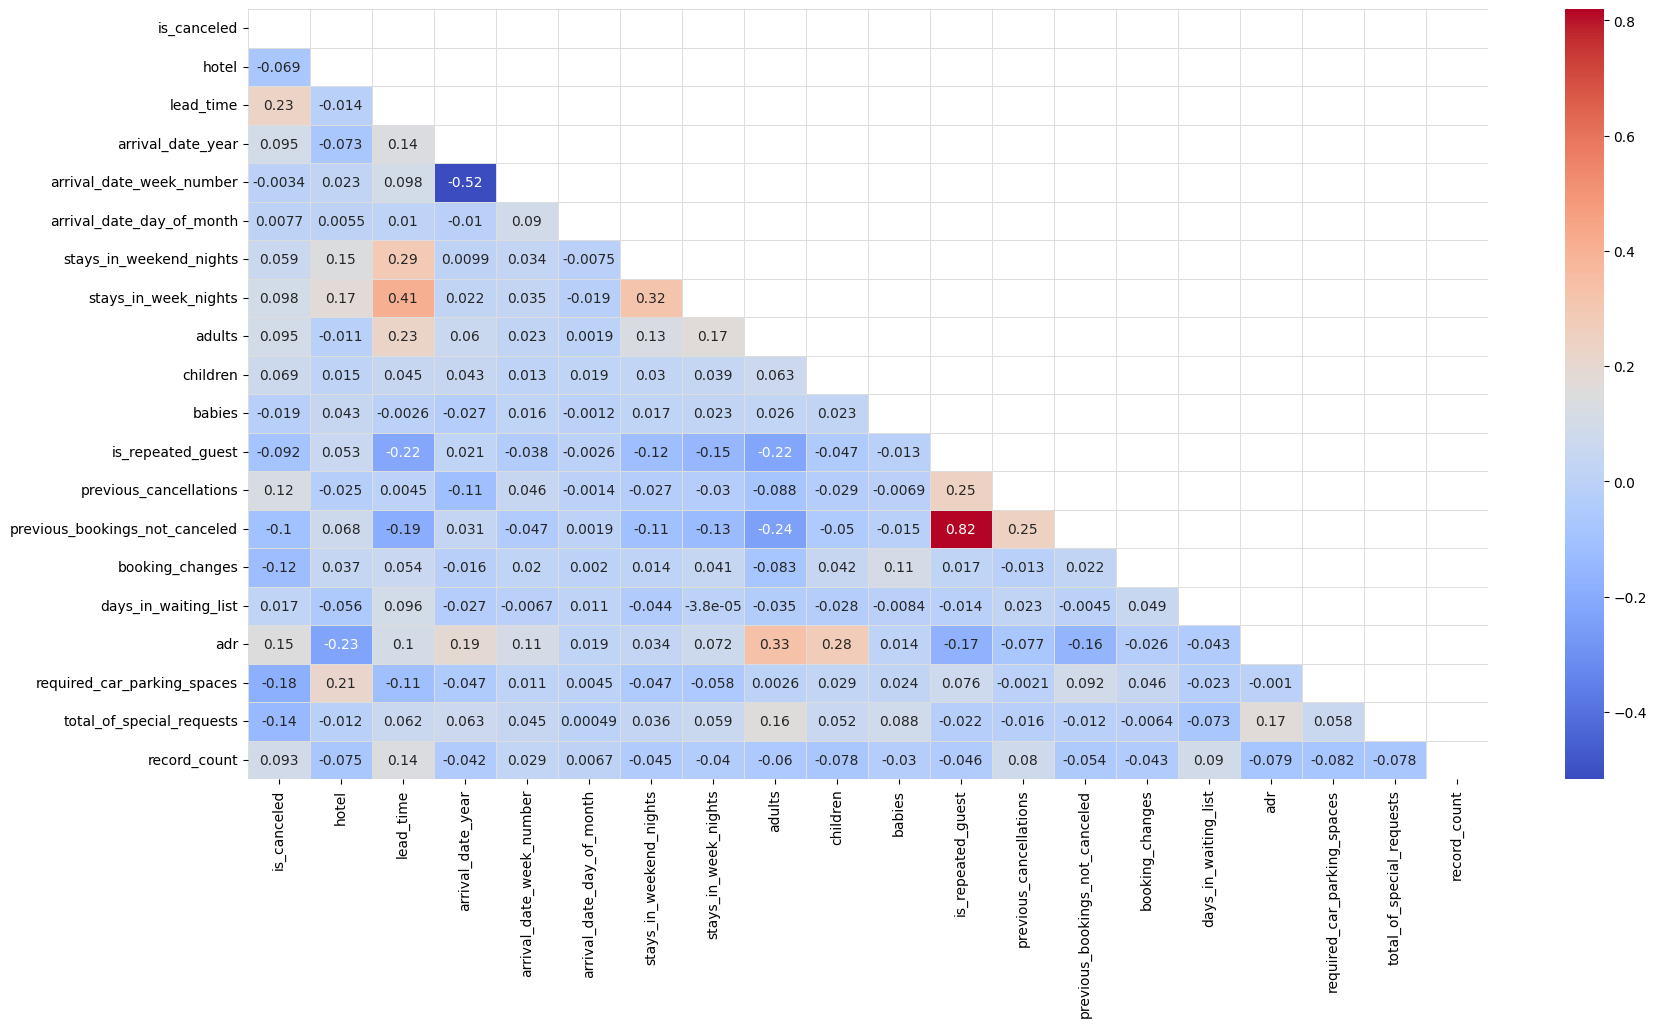

In [16]:
data = df_corr[numeric_cols]
corr = generate_corr_heatmap(data, lower_threshold=0)

View top ten features with strongest correlations to `is_canceled` (including one-hot encoded features)

In [22]:
corr = df_corr.corr(method='spearman')[target].sort_values(key=abs, ascending=False)[1:]
corr.head(10)

lead_time                       0.232180
market_segment_Online TA        0.204757
required_car_parking_spaces    -0.181133
deposit_type_Non Refund         0.166405
deposit_type_No Deposit        -0.164788
adr                             0.152838
market_segment_Offline TA/TO   -0.138671
distribution_channel_TA/TO      0.138051
total_of_special_requests      -0.137422
customer_type_Transient         0.133591
Name: is_canceled, dtype: float64

### Conclusions

When considering all records in the deduplicated dataset, no features are strongly associated with `is_canceled` but some are weakly associated.

Based on the analysis of all bookings combined, cancellations are somewhat more likely for bookings
- with **longer lead times**
- made through **Online Travel Agents**
- with a **non-refundable deposit**
- with a **higher average daily rate**
- booked via the **TA/TO distribution channel**
- made by **transient customers**

In contrast, bookings are less likely to be cancelled when they
- require **more car parking spaces**
- have **no deposit required**
- are made through **Offline Travel Agents or Tour Operators**
- include **special requests**

## 2. Unique vs Duplicated Records

### Analysis

Compare results for unique records and those with duplicates

In [18]:
# Split df_corr for unique and duplicate records
df_unique = df_corr[df_corr['record_count']==1]
df_duplicates = df_corr[df_corr['record_count']>1]

print('Unique records:', df_unique.shape[0])
print('Duplicated records:', df_duplicates.shape[0])

# Generate comparison table
col_headings = ['Unique', 'Duplicates']
summary = generate_corr_comparisons_table(df_unique, df_duplicates, col_headings, sort_by='Mean')
summary.head(10)

Unique records: 71875
Duplicated records: 7630


,Unique,Duplicates,Mean,Diff
deposit_type_Non Refund,0.08,0.39,0.23,-0.31
deposit_type_No Deposit,-0.07,-0.39,-0.23,0.31
lead_time,0.22,0.22,0.22,0.01
customer_type_Transient,0.14,0.30,0.22,-0.16
customer_type_Transient-Party,-0.11,-0.29,-0.20,0.18
record_count,NaN,0.20,0.20,NaN
previous_cancellations,0.09,0.28,0.18,-0.19
total_of_special_requests,-0.12,-0.22,-0.17,0.10
market_segment_Online TA,0.23,0.10,0.17,0.13
booking_changes,-0.11,-0.16,-0.14,0.05


Plot results to more easily compare differences

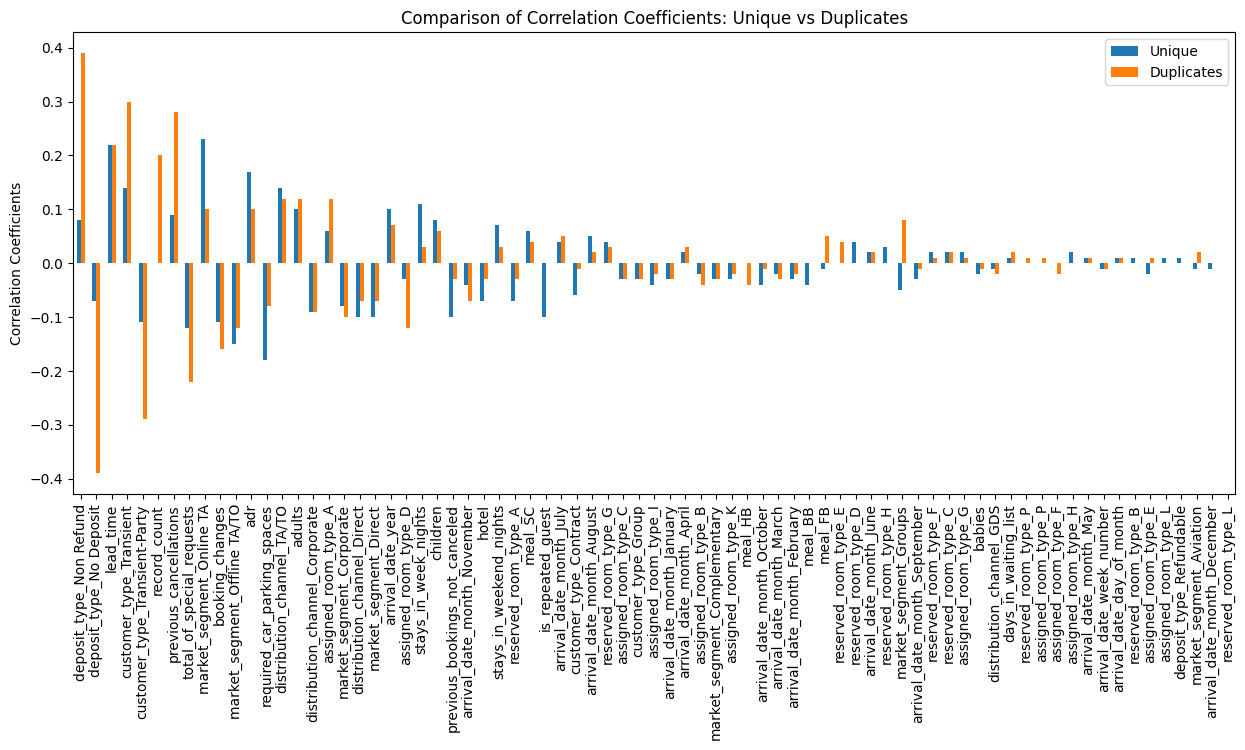

In [19]:
plot_corr_comparisons(summary, col_headings)

### Conclusions

There are clearly significant differences between how strongly the features correlate with cancellation rates in the two types of bookings. This further supports the assumption that duplicated records are by nature a different type of booking (e.g. bulk reservations or group bookings).

*NOTE: Similar differences in the associations of features are observed when the unique records subset is downsampled to the same size as the duplicated records subset. This confirms that the differences are not due to sample size but rather reflect different types of bookings.*

Although the strengths of associations are different, the direction of these associations are nearly always the same in each group. Therefore, it is not the case that correlations are cancelled out between the two groups. One notable exception is seen when considering the `market_segment` 'Groups' category which shows a weakly positive association with cancellation in the duplicates subset but a weakly negative association in the unique records subset. This provides further evidence for the different nature of the bookings in each subset.

The most strongly associated features in the unique records subset are:
- `market_segment`: 'Online TA' shows a weak positive association (+0.23) but 'Offline TA/TO' shows a weak negative association (-0.15)
- `lead_time`: shows a weak positive association (+0.22)
- `required_car_parking_spaces`: shows a weak negative association (-0.18)
- `adr`: shows a weak positive association (+0.17)
- `customer_type`: 'Transient' shows a weak positive association (+0.14) but 'Transient Party' shows a weak negative association (-0.11)
- `previous_cancellations`: shows a weak positive association (+0.28)
- `total_of_special_requests`: shows a weak negative association (-0.12)
- `booking_changes`: shows a weak negative association (-0.11)

The most strongly associated features in the duplicates subset are:
- `deposit_type`: 'Non Refund' shows a moderately positive association (+0.39) but 'No Deposit' shows a moderately negative association (-0.39)
- `customer_type`: 'Transient' shows a weak positive association (+0.30) but 'Transient Party' shows a weak negative association (-0.29)
- `previous_cancellations`: shows a weak positive association (+0.28)
- `total_of_special_requests`: shows a weak negative association (-0.22)
- `lead_time`: shows a weak positive association (+0.22) - *this is the same as in the unique dataset*
- `record_count`: shows a weak positive association (+0.20)
- `booking_changes`: shows a weak negative association (-0.16)

Since some features are more strongly associated with cancellations in one subset but not the other, predictors do not have uniform predictive power across all booking types and need to be considered separately for each group.

**UNIQUE BOOKINGS**

Based on the analysis of unique bookings, cancellations are somewhat more likely for bookings
- made through **Online Travel Agents**
- for **transient customers**
- with **longer lead times**
- made by guests with a history of **previous cancellations**.

In contrast, bookings are less likely to be cancelled when they
- are made through **Offline Travel Agents or Tour Operators**
- involve **transient-party customers**
- require **more car parking spaces**
- include **special requests** or **booking changes**


**DUPLICATED BOOKINGS**

Based on the analysis of duplicated bookings, cancellations are somewhat more likely for bookings
- with a **non-refundable deposit**
- made by **transient customers**
- with **longer lead times**
- associated with a **higher record count** (i.e. bookings made multiple times)
- made by guests with a **history of previous cancellations**

In contrast, bookings are less likely to be cancelled when they
- have **no deposit** required
- involve **transient-party customers**
- include **special requests** or **booking changes**


**IMPLICATIONS FOR HYPOTHESIS 3**

Hypothesis:
> "Bookings with higher average daily rates tend to cancel more."

The analysis supports this hypothesis to some extent. In both unique and duplicated bookings there is a very weak positive association with whether a booking will be cancelled. However, other features have stronger associations with cancellation rates and this feature should not be considered a main driver as to whether a booking will be cancelled.

**IMPLICATIONS FOR ML MODELS**

ML models may need to consider interactions with booking type (unique vs duplicated) or even train separate models for each subset.


## 3. City Hotel vs Resort Hotel

### Analysis

Compare results for city and resort hotels

In [20]:
# Split df_corr for unique and duplicate records
df_city = df_corr[df_corr['hotel']==0]
df_hotel = df_corr[df_corr['hotel']==1]

print('City hotel records:', df_city.shape[0])
print('Resort hotel records:', df_hotel.shape[0])

# Generate comparison table
col_headings = ['City', 'Resort']
summary = generate_corr_comparisons_table(df_city, df_hotel, col_headings, sort_by='Mean')
summary.head(10)

City hotel records: 49716
Resort hotel records: 29789


,City,Resort,Mean,Diff
lead_time,0.22,0.25,0.24,-0.03
market_segment_Online TA,0.17,0.25,0.21,-0.08
required_car_parking_spaces,-0.12,-0.24,-0.18,0.12
adr,0.11,0.18,0.15,-0.08
deposit_type_Non Refund,0.19,0.10,0.15,0.09
deposit_type_No Deposit,-0.19,-0.10,-0.14,-0.09
market_segment_Offline TA/TO,-0.12,-0.15,-0.14,0.03
customer_type_Transient,0.13,0.14,0.13,-0.02
distribution_channel_TA/TO,0.12,0.14,0.13,-0.02
previous_cancellations,0.13,0.12,0.12,0.01


Plot results to more easily compare differences

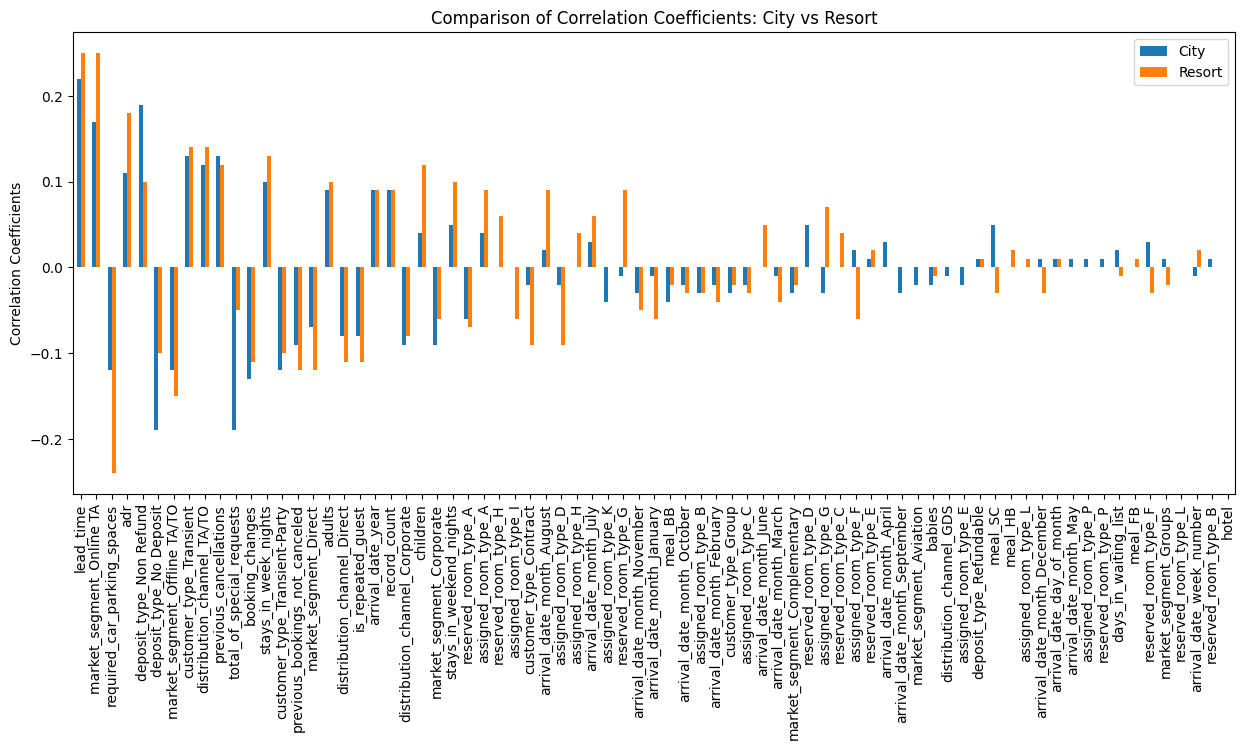

In [21]:
plot_corr_comparisons(summary, col_headings)

### Conclusions

Many of the same patterns observed earlier are seen again. There are no strong correlations but some features are weakly correlated.

There are differences in how strongly some features correlate with cancellation rates in the two types of hotel bookings. Although the strengths of associations are different, the direction of these associations are usually the same. The exceptions (meal types, room bookings) are very weakly associated with cancellation rates and not likely to be significant.

The most strongly associated features in the **City Hotel** subset are:
- `lead_time`: shows a weak positive association (+0.22)
- `deposit_type`: 'No Deposit' shows a weak negative association (-0.19) but 'Non Refund' shows a weak positive association (+0.19)
- `total_of_special_requests`: shows a weak negative association (-0.19)
- `market_segment`: 'Online TA' shows a weak positive association (+0.17) but 'Offline TA/TO' shows a weak negative association (-0.12)
- `customer_type`: 'Transient' shows a weak positive association (+0.13)
- `booking_changes`: shows a weak negative association (-0.13)
- `previous_cancellations`: shows a weak positive association (+0.13)
- `distribution_channel`: the 'TA/TO' category shows a weak positive association (+0.12)

The most strongly associated features in the **Resort Hotel** subset are:
- `lead_time`: shows a weak positive association (+0.25)
- `market_segment`: 'Online TA' shows a weak positive association (+0.25) but 'Offline TA/TO' shows a weak negative association (-0.15) and 'Direct' also shows a weak negative association (-0.12)
- `required_car_parking_spaces`: shows a weak negative association (-0.24)
- `adr`: shows a weak positive association (+0.18)
- `distribution_channel`: the 'TA/TO' category shows a weak positive association (+0.14)
- `customer_type`: 'Transient' shows a weak positive association (+0.14)
- `stays_in_week_nights`: shows a weak positive association (+0.13)
- `children`: shows a weak positive association (+0.12)

**Similarities**

In both hotels, bookings are more likely to cancel if they have:
- **longer lead times**
- booked via **travel agents**, especially **online travel agents**
- for **transient customers**
- been made by guests who have **previous cancellations**

Bookings are less likely to be cancelled if they are
- booked by **Offline travel agents or tour operators**

**Differences**

In the City Hotel, the following factors are more significant:
- **Deposit type**
  - 'No Deposit' corresponds with lower cancellations while 'Non Refund' corresponds with more cancellations
  - This likely reflects existing hotel practices for identify bookings at risk of cancellation
- **Special requests** and **booking changes**
  - Both tend to correlate with fewer cancellations

In the Resort Hotel, the following factors are more significant:
- **Required car parking spaces**
  - More car parking spaces tends to correlate with fewer cancellations
- **Average Daily Rate**
  - Although higher rates are correlated with more cancellations in both, the feature appears slightly more significant ranking in the top 4 features for the resort hotel but number 13 for the City hotel

**IMPLICATIONS FOR HYPOTHESIS 3**

Hypothesis:
> "Bookings with higher average daily rates tend to cancel more."

The analysis supports this hypothesis to some extent. In both hotels there is a very weak positive association with whether a booking will be cancelled. The correlation is more significant for the resort hotel than the city hotel but other features (e.g. lead times, market segment 'Online TA') have stronger associations with cancellation rates in both hotels. Therefore, this feature should not be considered a main driver as to whether a booking will be cancelled.


---